In [1]:
!pip install torch torchvision matplotlib tqdm seaborn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import copy

In [3]:
# 1. Early Exit CNN Architecture for CIFAR-10
class EarlyExitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EarlyExitCNN, self).__init__()

        # First block - Enhanced feature extraction
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Additional conv layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        # First exit point with better feature processing
        self.exit1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

        # Second block - Improved intermediate processing
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Second exit with residual connection
        self.exit2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

        # Third block - Advanced feature processing
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Third exit with enhanced classification
        self.exit3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )

        # Final block - Deep feature extraction
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Final exit with comprehensive classification
        self.final_exit = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x, return_all_exits=False):
        # Store intermediate features for each exit
        features = []

        # First block and exit
        x = self.block1(x)
        exit1_out = self.exit1(x)
        features.append(x)

        # Second block and exit
        x = self.block2(x)
        exit2_out = self.exit2(x)
        features.append(x)

        # Third block and exit
        x = self.block3(x)
        exit3_out = self.exit3(x)
        features.append(x)

        # Final block and exit
        x = self.block4(x)
        final_out = self.final_exit(x)
        features.append(x)

        if return_all_exits:
            return [exit1_out, exit2_out, exit3_out, final_out]
        return final_out

In [4]:
# 2. DQN Agent for Early Exit Decisions
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.state_size = state_size
        self.action_size = action_size

        # Larger network for more complex decisions
        self.q_network = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        ).to(self.device)  # Move to GPU

        # Modified exploration parameters
        self.epsilon = 1.0
        self.epsilon_min = 0.2
        self.epsilon_decay = 0.998  # Slower decay for more exploration
        self.learning_rate = 0.0005  # Adjusted learning rate

        self.target_network = copy.deepcopy(self.q_network).to(self.device)  # Move to GPU
        self.optimizer = optim.Adam(self.q_network.parameters(),
                                  lr=self.learning_rate,
                                  weight_decay=1e-5)
        self.memory = deque(maxlen=10000)

        self.gamma = 0.98
        self.target_update_freq = 100
        self.steps = 0

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Move to GPU
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        # Convert batch data to tensors and move to GPU
        states = torch.FloatTensor(np.array([x[0] for x in batch])).to(self.device)
        actions = torch.LongTensor([x[1] for x in batch]).to(self.device)
        rewards = torch.FloatTensor([x[2] for x in batch]).to(self.device)
        next_states = torch.FloatTensor(np.array([x[3] for x in batch])).to(self.device)
        dones = torch.FloatTensor([x[4] for x in batch]).to(self.device)

        # Use target network for more stable training
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q = self.target_network(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Huber loss for better stability
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# 3. Training Environment
class EarlyExitEnvironment:
    def __init__(self, model, compute_penalty=0.05):  # Reduced penalty
        self.model = model
        self.compute_penalty = compute_penalty
        self.current_exits = None
        self.current_target = None
        self.exit_index = 0
        # Adjusted confidence thresholds
        self.confidence_thresholds = [0.70, 0.80, 0.85, 0.0]

    def reset(self, input_data, target):
        with torch.no_grad():
            self.current_exits = self.model(input_data, return_all_exits=True)
            self.current_target = target
            self.exit_index = 0
    
            confidences = F.softmax(self.current_exits[0], dim=1)
            max_conf = confidences.max(1)[0]
            return max_conf.cpu().numpy() 

    def step(self, action):
        done = False
        reward = 0
    
        # Calculate confidence scores first
        confidences = F.softmax(self.current_exits[self.exit_index], dim=1)
        max_conf = confidences.max(1)[0]
    
        if action == 1:  # continue
            if self.exit_index < len(self.current_exits) - 1:
                self.exit_index += 1
                # Smaller penalty for continuing
                reward = -self.compute_penalty
            else:
                done = True
    
            next_state = max_conf.cpu().numpy()  # Added .cpu()
    
        else:  # exit
            prediction = self.current_exits[self.exit_index].argmax(1)
            correct = (prediction == self.current_target).item()
    
            # Enhanced rewards for correct predictions at later exits
            if correct:
                base_reward = 1.0
                # Higher reward for correct early exits
                exit_bonus = (3 - self.exit_index) * 0.3
                confidence_bonus = max_conf.item() * 0.2
                reward = base_reward + exit_bonus + confidence_bonus
            else:
                # Larger penalty for incorrect early exits
                confidence_penalty = (1 - max_conf.item()) * 0.5
                reward = -1.0 - confidence_penalty
    
            done = True
            next_state = None
    
        return next_state, reward, done

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [7]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load cifar 10 data
def load_cifar10_data(batch_size=128):
    """
    Load and prepare CIFAR-10 dataset with appropriate transformations.
    We add some basic data augmentation for training to improve generalization.
    """
    # Training data transforms with augmentation
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Add padding and random crop for robustness
        transforms.RandomHorizontalFlip(),     # Random flipping for augmentation
        transforms.ToTensor(),
        # CIFAR-10 normalization values (pre-computed mean and std)
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    # Test data only needs basic transforms
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010))
    ])

    # Load training data
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    # Load test data
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader

In [9]:
# Initialize models and move to device
def initialize_models():
    """
    Initialize the CNN and DQN models and move them to the correct device
    """
    # Create CNN model
    cnn_model = EarlyExitCNN().to(device)

    # Create DQN agent
    # State size is 1 (confidence score), action size is 2 (exit or continue)
    dqn_agent = DQNAgent(state_size=1, action_size=2)
    dqn_agent.q_network = dqn_agent.q_network.to(device)

    # Create environment
    env = EarlyExitEnvironment(cnn_model)

    return cnn_model, dqn_agent, env

In [10]:
# Test the setup
def test_setup():
    # Load data
    train_loader, test_loader = load_cifar10_data(batch_size=64)
    print(f"Training batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Initialize models
    cnn_model, dqn_agent, env = initialize_models()
    print("\nModel architectures:")
    print(cnn_model)
    print("\nDQN network:")
    print(dqn_agent.q_network)

    # Test forward pass
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    images = images.to(device)

    # Test CNN forward pass
    exits = cnn_model(images, return_all_exits=True)
    print("\nExit outputs shapes:")
    for i, exit_output in enumerate(exits):
        print(f"Exit {i+1}: {exit_output.shape}")

    # Test DQN forward pass
    sample_state = torch.randn(1, 1).to(device)
    q_values = dqn_agent.q_network(sample_state)
    print(f"\nQ-values shape: {q_values.shape}")

    print("\nSetup completed successfully!")

# Run the test
test_setup()

Files already downloaded and verified
Files already downloaded and verified
Training batches: 782
Test batches: 157

Model architectures:
EarlyExitCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (exit1): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
  (block2): Sequential(
    (0): Conv2

In [11]:
def pretrain_cnn(model, train_loader, val_loader=None, num_epochs=20):
    """
    Enhanced pre-training with dynamic exit weights, validation monitoring,
    and improved optimization strategy.
    """
    print("Pre-training CNN...")
    model.train()

    # Training metrics
    train_losses = []
    accuracies_per_exit = [[] for _ in range(4)]
    best_val_acc = 0
    patience = 5
    patience_counter = 0

    # Optimizer with cosine annealing
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6  # Adjusted for 50 epochs
    )

    def get_dynamic_weights(epoch, num_epochs):
        """Calculate dynamic weights for exits based on training progress"""
        progress = epoch / num_epochs
        # Gradually shift importance to later exits
        weights = torch.tensor([
            0.4 * (1 - progress),  # Decrease weight of first exit
            0.2 + 0.1 * progress,  # Slightly increase second exit
            0.2 + 0.2 * progress,  # Moderately increase third exit
            0.2 + 0.3 * progress   # Significantly increase final exit
        ]).to(device)
        return weights / weights.sum()  # Normalize weights

    def validate_model(model, val_loader):
        """Evaluate model performance on validation set"""
        model.eval()
        val_losses = []
        correct_per_exit = [0] * 4
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                exits = model(data, return_all_exits=True)

                for i, exit_output in enumerate(exits):
                    loss = F.cross_entropy(exit_output, target)
                    val_losses.append(loss.item())
                    pred = exit_output.argmax(dim=1)
                    correct_per_exit[i] += pred.eq(target).sum().item()
                total += len(target)

        # Calculate accuracies
        accuracies = [100 * correct / total for correct in correct_per_exit]
        avg_loss = sum(val_losses) / len(val_losses)

        model.train()
        return avg_loss, accuracies

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = [0] * 4
        total_samples = 0

        # Get dynamic weights for this epoch
        exit_weights = get_dynamic_weights(epoch, num_epochs)

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Get predictions from all exits
            exits = model(data, return_all_exits=True)

            # Compute weighted loss with dynamic weights
            loss = 0
            for i, (exit_output, weight) in enumerate(zip(exits, exit_weights)):
                exit_loss = F.cross_entropy(exit_output, target)
                loss += weight * exit_loss

                # Track accuracy
                pred = exit_output.argmax(dim=1)
                correct_predictions[i] += pred.eq(target).sum().item()

            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            total_samples += len(data)

            # Update progress bar with metrics
            avg_loss = epoch_loss/(batch_idx+1)
            accuracies = [correct/total_samples * 100 for correct in correct_predictions]
            progress_bar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc1': f'{accuracies[0]:.1f}%',
                'acc2': f'{accuracies[1]:.1f}%',
                'acc3': f'{accuracies[2]:.1f}%',
                'acc4': f'{accuracies[3]:.1f}%'
            })

        # Validation phase
        if val_loader is not None:
            val_loss, val_accuracies = validate_model(model, val_loader)
            print(f"\nValidation - Loss: {val_loss:.4f}, "
                  f"Accuracies: {[f'{acc:.1f}%' for acc in val_accuracies]}")

            # Early stopping check
            current_val_acc = val_accuracies[-1]  # Use final exit accuracy
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered!")
                    break

        # Update learning rate
        scheduler.step()

        # Store metrics
        train_losses.append(avg_loss)
        for i in range(4):
            accuracies_per_exit[i].append(accuracies[i])

    print("CNN pre-training completed!")
    return train_losses, accuracies_per_exit

In [12]:
def train_rl_agent(model, agent, env, train_loader, num_episodes=1000):
    """
    Train the RL agent to learn when to exit the network.
    Modified for CIFAR-10 with adjusted rewards and monitoring.
    """
    print("Training RL agent...")
    model.eval()  # Set CNN to evaluation mode

    episode = 0
    total_rewards = []
    exit_counts = [0, 0, 0, 0]  # Track which exits are being used
    running_accuracy = []

    progress_bar = tqdm(total=num_episodes, desc='Training RL agent')

    while episode < num_episodes:
        for data, target in train_loader:
            if episode >= num_episodes:
                break

            data, target = data.to(device), target.to(device)

            for i in range(len(data)):  # Process each sample in batch
                # Reset environment with new sample
                state = env.reset(data[i:i+1], target[i:i+1])
                total_reward = 0
                correct = False

                while True:
                    # Get action from agent
                    action = agent.get_action(state)

                    # Take action in environment
                    next_state, reward, done = env.step(action)

                    if done:
                        exit_counts[env.exit_index] += 1
                        if reward > 0:  # Track if prediction was correct
                            correct = True

                    # Store experience in memory
                    if next_state is not None:
                        agent.remember(state, action, reward, next_state, done)

                    total_reward += reward

                    if done:
                        break

                    state = next_state

                # Train agent
                agent.train()

                total_rewards.append(total_reward)
                running_accuracy.append(1.0 if correct else 0.0)
                if len(running_accuracy) > 100:  # Keep track of last 100 episodes
                    running_accuracy.pop(0)

                episode += 1

                # Update progress
                if episode % 10 == 0:
                    avg_reward = sum(total_rewards[-100:]) / min(len(total_rewards), 100)
                    avg_accuracy = sum(running_accuracy) / len(running_accuracy)
                    exit_distribution = [count/episode*100 for count in exit_counts]

                    progress_bar.set_postfix({
                        'avg_reward': f'{avg_reward:.2f}',
                        'accuracy': f'{avg_accuracy:.2f}',
                        'epsilon': f'{agent.epsilon:.2f}',
                        'exit_dist': f'[{exit_distribution[0]:.1f}%, {exit_distribution[1]:.1f}%, {exit_distribution[2]:.1f}%, {exit_distribution[3]:.1f}%]'
                    })
                    progress_bar.update(10)

                if episode >= num_episodes:
                    break

    print("RL agent training completed!")
    return total_rewards, exit_counts

In [13]:
def evaluate_model(model, agent, test_loader):
    """
    Enhanced evaluation with confidence calibration, per-class metrics,
    and detailed analysis of exit decisions.
    """
    print("Evaluating model...")
    model.eval()

    # Tracking metrics
    correct = 0
    total = 0
    exit_counts = [0] * 4
    class_correct = [0] * 10
    class_total = [0] * 10
    compute_saved = 0
    confidence_stats = [[] for _ in range(4)]
    exit_decision_changes = 0  # Track when predictions change between exits

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    def get_calibrated_confidence(logits, temperature=1.0):
        """Apply temperature scaling for better calibrated confidence scores"""
        scaled_logits = logits / temperature
        probs = F.softmax(scaled_logits, dim=1)
        return probs.max(1)[0]

    def analyze_prediction_stability(exits, confidences):
        """Analyze how predictions change across exits"""
        predictions = [exit.argmax(dim=1) for exit in exits]
        changes = sum(1 for i in range(1, len(predictions))
                     if predictions[i] != predictions[i-1])
        return changes, predictions

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            batch_size = len(data)

            for i in range(batch_size):
                sample = data[i:i+1]
                sample_target = target[i:i+1]

                # Get predictions from all exits
                exits = model(sample, return_all_exits=True)

                # Get calibrated confidences
                confidences = [get_calibrated_confidence(exit) for exit in exits]

                # Analyze prediction stability
                pred_changes, predictions = analyze_prediction_stability(exits, confidences)

                # Initialize state with first exit's confidence
                state = confidences[0].cpu().numpy()
                exit_point = 0
                prev_pred = None

                # Let agent make exit decisions
                while True:
                    action = agent.get_action(state)

                    # Enhanced exit decision logic
                    current_pred = exits[exit_point].argmax(dim=1)
                    current_conf = confidences[exit_point].item()

                    # Store confidence statistics
                    confidence_stats[exit_point].append(current_conf)

                    # Track prediction changes
                    if prev_pred is not None and current_pred != prev_pred:
                        exit_decision_changes += 1

                    # Exit conditions with adaptive thresholds
                    if action == 0:
                        # Check if confidence is high enough for this exit
                        min_conf = 0.98 - (exit_point * 0.05)  # Adaptive threshold
                        if current_conf >= min_conf:
                            break
                        elif exit_point < len(exits) - 1:
                            exit_point += 1
                            state = confidences[exit_point].cpu().numpy()
                            prev_pred = current_pred
                            continue

                    if exit_point == len(exits) - 1:
                        break

                    exit_point += 1
                    state = confidences[exit_point].cpu().numpy()
                    prev_pred = current_pred

                # Record exit point
                exit_counts[exit_point] += 1

                # Check accuracy
                final_prediction = exits[exit_point].argmax(dim=1)
                correct_prediction = final_prediction.eq(sample_target).item()
                correct += correct_prediction
                total += 1

                # Update per-class accuracy
                class_idx = sample_target.item()
                class_correct[class_idx] += correct_prediction
                class_total[class_idx] += 1

                # Calculate compute saved
                compute_saved += (3 - exit_point) / 3

    # Calculate overall metrics
    accuracy = 100. * correct / total
    exit_distribution = [count/total*100 for count in exit_counts]
    compute_saved = compute_saved / total * 100

    # Calculate confidence statistics
    confidence_means = [np.mean(confs) if confs else 0 for confs in confidence_stats]
    confidence_stds = [np.std(confs) if confs else 0 for confs in confidence_stats]

    # Print comprehensive evaluation results
    print(f"\nTest Results:")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Exit Distribution: Exit1={exit_distribution[0]:.1f}%, "
          f"Exit2={exit_distribution[1]:.1f}%, "
          f"Exit3={exit_distribution[2]:.1f}%, "
          f"Exit4={exit_distribution[3]:.1f}%")
    print(f"Compute Saved: {compute_saved:.1f}%")
    print(f"Prediction Changes Between Exits: {exit_decision_changes}")

    print("\nConfidence Statistics:")
    for i in range(4):
        print(f"Exit {i+1}: Mean={confidence_means[i]:.3f}, Std={confidence_stds[i]:.3f}")

    print("\nPer-class Accuracy:")
    for i in range(10):
        class_acc = 100 * class_correct[i] / class_total[i]
        print(f'{classes[i]}: {class_acc:.2f}%')

    # Calculate effectiveness score
    effectiveness = accuracy * (compute_saved/100)  # Balance between accuracy and efficiency
    print(f"\nEffectiveness Score: {effectiveness:.2f}")

    return {
        'accuracy': accuracy,
        'exit_distribution': exit_distribution,
        'compute_saved': compute_saved,
        'confidence_stats': {
            'means': confidence_means,
            'stds': confidence_stds
        },
        'class_accuracies': [100 * correct / total for correct, total in zip(class_correct, class_total)],
        'effectiveness': effectiveness,
        'exit_decision_changes': exit_decision_changes
    }

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
def plot_training_metrics(train_losses, accuracies_per_exit, exit_distributions):
    """
    Visualize training progress with multiple metrics.
    Shows loss curve, accuracy per exit point, and exit point distribution.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss Over Time')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plot accuracy for each exit
    for i, accs in enumerate(accuracies_per_exit):
        ax2.plot(accs, label=f'Exit {i+1}')
    ax2.set_title('Accuracy per Exit Point')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Plot exit distribution
    exits = ['Exit 1', 'Exit 2', 'Exit 3', 'Exit 4']
    ax3.bar(exits, exit_distributions)
    ax3.set_title('Exit Point Distribution')
    ax3.set_ylabel('Percentage of Samples')
    ax3.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

In [16]:
def visualize_class_exits(model, agent, test_loader, num_samples=50):
    """
    Visualize which classes tend to exit at which points.
    Creates a heatmap showing the relationship between classes and exit points.
    """
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    exit_stats = np.zeros((10, 4))  # 10 classes, 4 exit points
    class_counts = np.zeros(10)

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            for i in range(len(data)):
                sample = data[i:i+1]
                label = target[i].item()

                # Get predictions from all exits
                exits = model(sample, return_all_exits=True)

                # Determine exit point using agent
                state = F.softmax(exits[0], dim=1).max(1)[0].cpu().numpy()
                exit_point = 0

                while True:
                    action = agent.get_action(state)
                    if action == 0 or exit_point == len(exits) - 1:
                        break
                    exit_point += 1
                    state = F.softmax(exits[exit_point], dim=1).max(1)[0].cpu().numpy()

                exit_stats[label, exit_point] += 1
                class_counts[label] += 1

                if np.sum(class_counts) >= num_samples * 10:
                    break
            if np.sum(class_counts) >= num_samples * 10:
                break

    # Normalize by class counts
    exit_stats = exit_stats / class_counts[:, np.newaxis] * 100

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(exit_stats,
                xticklabels=['Exit 1', 'Exit 2', 'Exit 3', 'Exit 4'],
                yticklabels=classes,
                annot=True,
                fmt='.1f',
                cmap='YlOrRd')
    plt.title('Exit Point Distribution by Class (%)')
    plt.xlabel('Exit Point')
    plt.ylabel('Class')
    plt.show()

In [17]:
def visualize_exit_decisions(model, agent, test_loader, num_samples=10):
    """
    Visualize sample images and their exit points.
    Shows confidence levels and actual vs predicted classes.
    """
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    with torch.no_grad():
        for i, (image, label) in enumerate(zip(images, labels)):
            # Get predictions from all exits
            exits = model(image.unsqueeze(0), return_all_exits=True)

            # Get confidence scores and determine exit point
            confidences = [F.softmax(exit, dim=1).max(1)[0].item() for exit in exits]

            state = confidences[0]
            exit_point = 0
            while True:
                action = agent.get_action([state])
                if action == 0 or exit_point == len(exits) - 1:
                    break
                exit_point += 1
                state = confidences[exit_point]

            # Get prediction
            pred = exits[exit_point].argmax(1).item()

            # Plot image
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Denormalize image
            img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
            img = np.clip(img, 0, 1)

            axes[i].imshow(img)
            axes[i].axis('off')
            title = f'True: {classes[label]}\nPred: {classes[pred]}\nExit: {exit_point+1}\nConf: {confidences[exit_point]:.2f}'
            # Color code the title based on correct/incorrect prediction
            color = 'green' if pred == label else 'red'
            axes[i].set_title(title, color=color)

    plt.tight_layout()
    plt.show()

In [18]:
def plot_confidence_distributions(model, test_loader):
    """
    Plot confidence distribution at each exit point.
    Shows how confidence levels vary across different exits.
    """
    confidences_per_exit = [[] for _ in range(4)]

    model.eval()
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            exits = model(data, return_all_exits=True)

            for i, exit in enumerate(exits):
                confs = F.softmax(exit, dim=1).max(1)[0].cpu().numpy()
                confidences_per_exit[i].extend(confs)

    plt.figure(figsize=(12, 6))
    for i, confs in enumerate(confidences_per_exit):
        plt.hist(confs, bins=50, alpha=0.5, label=f'Exit {i+1}')

    plt.title('Confidence Distribution at Each Exit')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def analyze_per_class_exits(model, test_loader, device):
    """
    Analyzes the performance of each exit point for each class.
    Returns detailed metrics about accuracy and confidence per class per exit.
    """
    model.eval()

    # Initialize tracking matrices
    num_classes = 10
    num_exits = 4

    # Track correct predictions and total instances for each class at each exit
    correct_per_class_exit = torch.zeros((num_exits, num_classes))
    total_per_class_exit = torch.zeros((num_exits, num_classes))

    # Track confidence scores
    confidence_sums = torch.zeros((num_exits, num_classes))

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc='Analyzing exits'):
            data, targets = data.to(device), targets.to(device)

            # Get predictions from all exits
            exits = model(data, return_all_exits=True)

            # Analyze each exit point
            for exit_idx, exit_output in enumerate(exits):
                # Get predictions and confidence scores
                confidences, predictions = torch.max(F.softmax(exit_output, dim=1), dim=1)

                # Update metrics for each class
                for class_idx in range(num_classes):
                    # Create mask for current class
                    class_mask = targets == class_idx

                    # Count total instances of this class
                    total_per_class_exit[exit_idx][class_idx] += class_mask.sum().item()

                    # Count correct predictions for this class
                    correct_predictions = (predictions == targets) & class_mask
                    correct_per_class_exit[exit_idx][class_idx] += correct_predictions.sum().item()

                    # Sum confidence scores for this class
                    confidence_sums[exit_idx][class_idx] += confidences[class_mask].sum().item()

    # Calculate accuracies and average confidences
    accuracies = correct_per_class_exit / total_per_class_exit
    avg_confidences = confidence_sums / total_per_class_exit

    # Print detailed analysis
    print("\nPer-Class Accuracy at Each Exit Point:")
    print("-" * 50)

    for class_idx, class_name in enumerate(classes):
        print(f"\n{class_name.upper()}:")
        for exit_idx in range(num_exits):
            acc = accuracies[exit_idx][class_idx] * 100
            conf = avg_confidences[exit_idx][class_idx]
            total = total_per_class_exit[exit_idx][class_idx]
            print(f"Exit {exit_idx + 1}: "
                  f"Accuracy = {acc:.2f}%, "
                  f"Avg Confidence = {conf:.3f}, "
                  f"Samples = {total:.0f}")

    # Return detailed metrics for visualization
    return {
        'accuracies': accuracies.numpy(),
        'confidences': avg_confidences.numpy(),
        'totals': total_per_class_exit.numpy(),
        'classes': classes
    }

In [20]:
def visualize_exit_analysis(metrics):
    """
    Creates visualizations of the exit analysis results.
    """
    accuracies = metrics['accuracies']
    classes = metrics['classes']

    # Create accuracy comparison plot
    plt.figure(figsize=(15, 8))
    x = np.arange(len(classes))
    width = 0.2

    for i in range(4):
        plt.bar(x + i*width, accuracies[i] * 100, width,
                label=f'Exit {i+1}')

    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy at Each Exit')
    plt.xticks(x + width*1.5, classes, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create heatmap of accuracies
    plt.figure(figsize=(12, 8))
    sns.heatmap(accuracies * 100,
                xticklabels=classes,
                yticklabels=[f'Exit {i+1}' for i in range(4)],
                annot=True,
                fmt='.1f',
                cmap='YlOrRd')
    plt.title('Accuracy Heatmap: Exits vs Classes')
    plt.tight_layout()
    plt.show()

In [21]:
def run_training_pipeline():
    print("Starting improved training pipeline...")

    # Load data with more varied batch sizes
    train_loader, test_loader = load_cifar10_data(batch_size=128)
    # Initialize models
    cnn_model, dqn_agent, env = initialize_models()

    # Pre-train CNN for more epochs
    train_losses, accuracies_per_exit = pretrain_cnn(cnn_model, train_loader, num_epochs=50)

    # Train RL agent with more episodes
    rewards, exit_counts = train_rl_agent(
        cnn_model,
        dqn_agent,
        env,
        train_loader,
        num_episodes=5000
    )

    # Evaluate and visualize
    metrics = evaluate_model(
        cnn_model,
        dqn_agent,
        test_loader
    )

    # Add our new detailed exit analysis
    print("\nPerforming detailed exit analysis...")
    exit_metrics = analyze_per_class_exits(cnn_model, test_loader, device)
    visualize_exit_analysis(exit_metrics)

    # Existing visualizations
    plot_training_metrics(
        train_losses=train_losses,
        accuracies_per_exit=accuracies_per_exit,
        exit_distributions=metrics['exit_distribution']
    )

    visualize_exit_decisions(cnn_model, dqn_agent, test_loader)
    visualize_class_exits(cnn_model, dqn_agent, test_loader)
    plot_confidence_distributions(cnn_model, test_loader)

    return cnn_model, dqn_agent, metrics, exit_metrics

Starting improved training pipeline...
Files already downloaded and verified
Files already downloaded and verified
Pre-training CNN...


Epoch 1/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/391 [00:00<?, ?it/s]

CNN pre-training completed!
Training RL agent...


Training RL agent:   0%|          | 0/5000 [00:00<?, ?it/s]

RL agent training completed!
Evaluating model...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Test Results:
Overall Accuracy: 88.82%
Exit Distribution: Exit1=5.3%, Exit2=34.3%, Exit3=31.7%, Exit4=28.6%
Compute Saved: 38.8%
Prediction Changes Between Exits: 4216

Confidence Statistics:
Exit 1: Mean=0.677, Std=0.215
Exit 2: Mean=0.794, Std=0.208
Exit 3: Mean=0.838, Std=0.185
Exit 4: Mean=0.711, Std=0.178

Per-class Accuracy:
plane: 92.10%
car: 96.00%
bird: 83.20%
cat: 82.10%
deer: 87.90%
dog: 79.30%
frog: 94.30%
horse: 88.10%
ship: 93.70%
truck: 91.50%

Effectiveness Score: 34.46

Performing detailed exit analysis...


Analyzing exits:   0%|          | 0/79 [00:00<?, ?it/s]


Per-Class Accuracy at Each Exit Point:
--------------------------------------------------

PLANE:
Exit 1: Accuracy = 68.40%, Avg Confidence = 0.722, Samples = 1000
Exit 2: Accuracy = 86.80%, Avg Confidence = 0.820, Samples = 1000
Exit 3: Accuracy = 92.90%, Avg Confidence = 0.912, Samples = 1000
Exit 4: Accuracy = 92.20%, Avg Confidence = 0.920, Samples = 1000

CAR:
Exit 1: Accuracy = 78.30%, Avg Confidence = 0.765, Samples = 1000
Exit 2: Accuracy = 92.30%, Avg Confidence = 0.901, Samples = 1000
Exit 3: Accuracy = 95.70%, Avg Confidence = 0.960, Samples = 1000
Exit 4: Accuracy = 96.10%, Avg Confidence = 0.969, Samples = 1000

BIRD:
Exit 1: Accuracy = 45.50%, Avg Confidence = 0.612, Samples = 1000
Exit 2: Accuracy = 76.40%, Avg Confidence = 0.748, Samples = 1000
Exit 3: Accuracy = 84.20%, Avg Confidence = 0.876, Samples = 1000
Exit 4: Accuracy = 83.40%, Avg Confidence = 0.875, Samples = 1000

CAT:
Exit 1: Accuracy = 47.10%, Avg Confidence = 0.554, Samples = 1000
Exit 2: Accuracy = 76.70

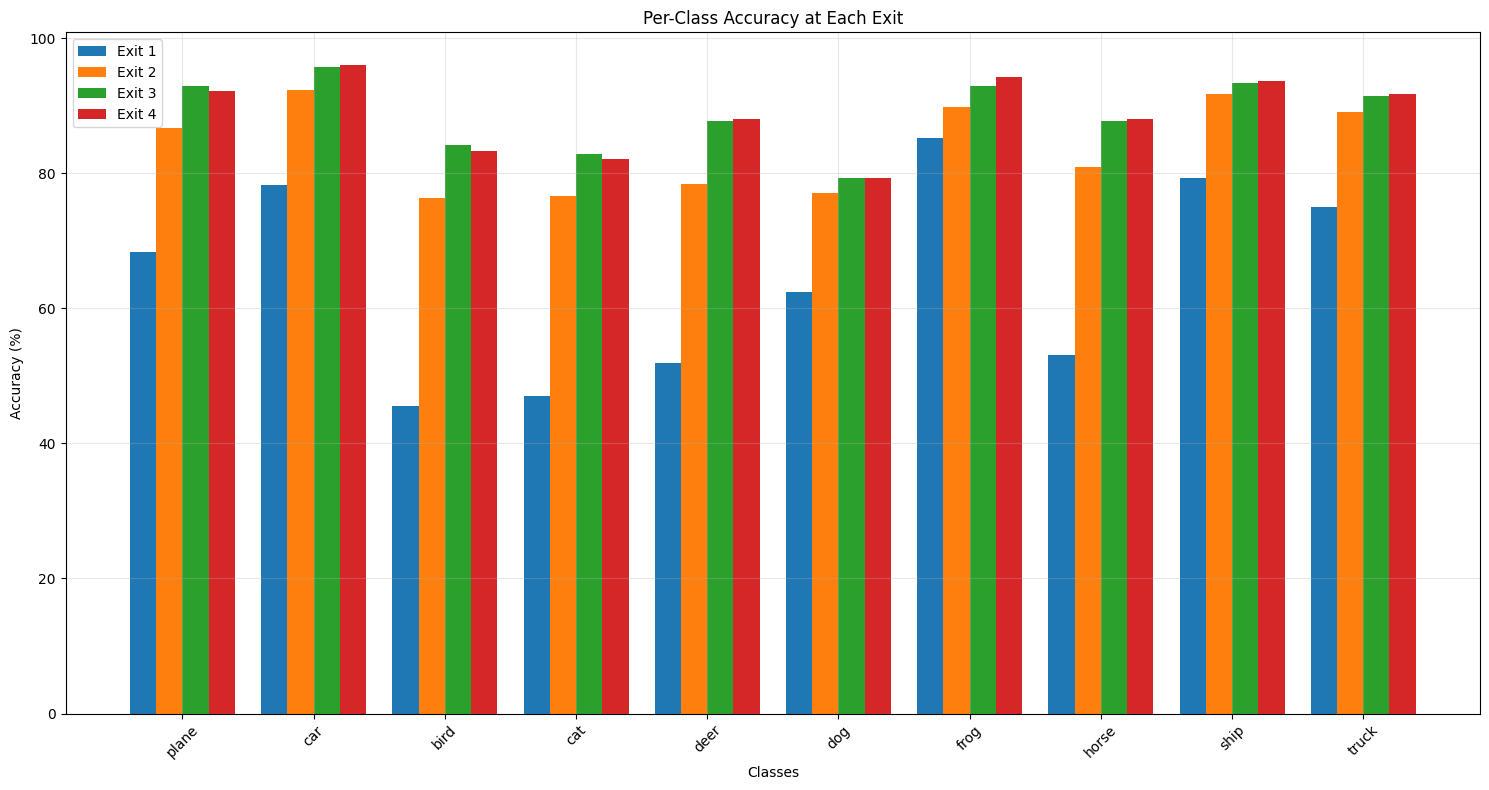

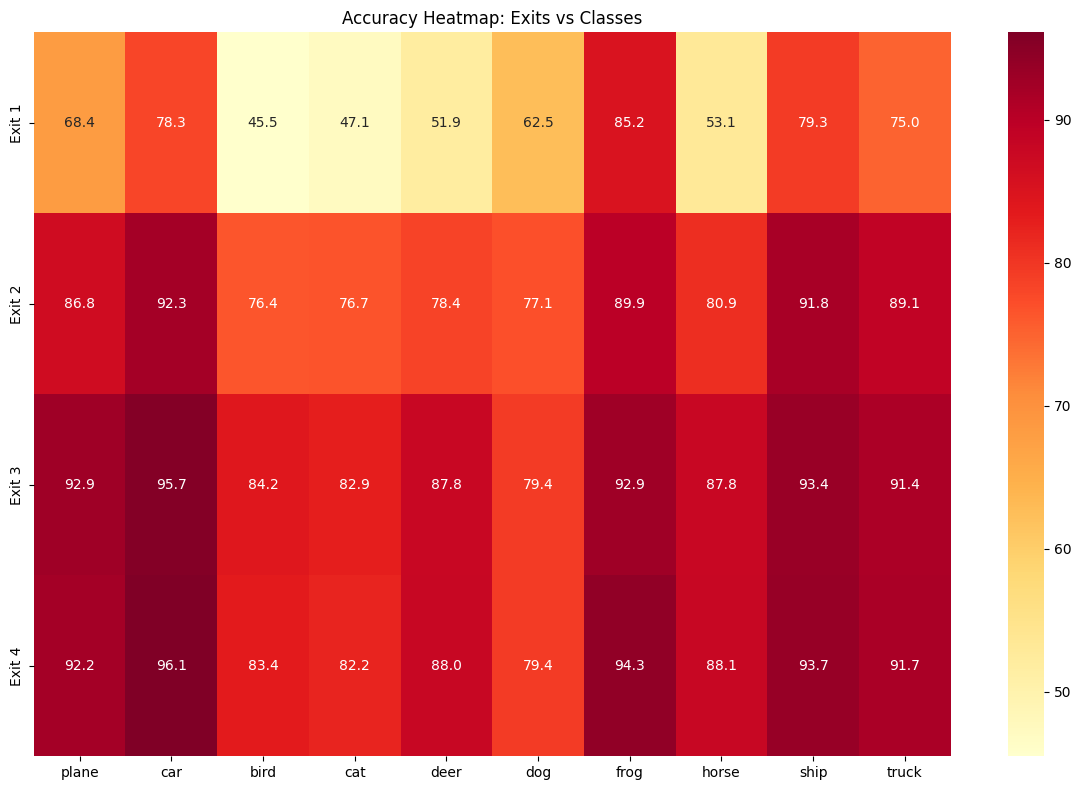

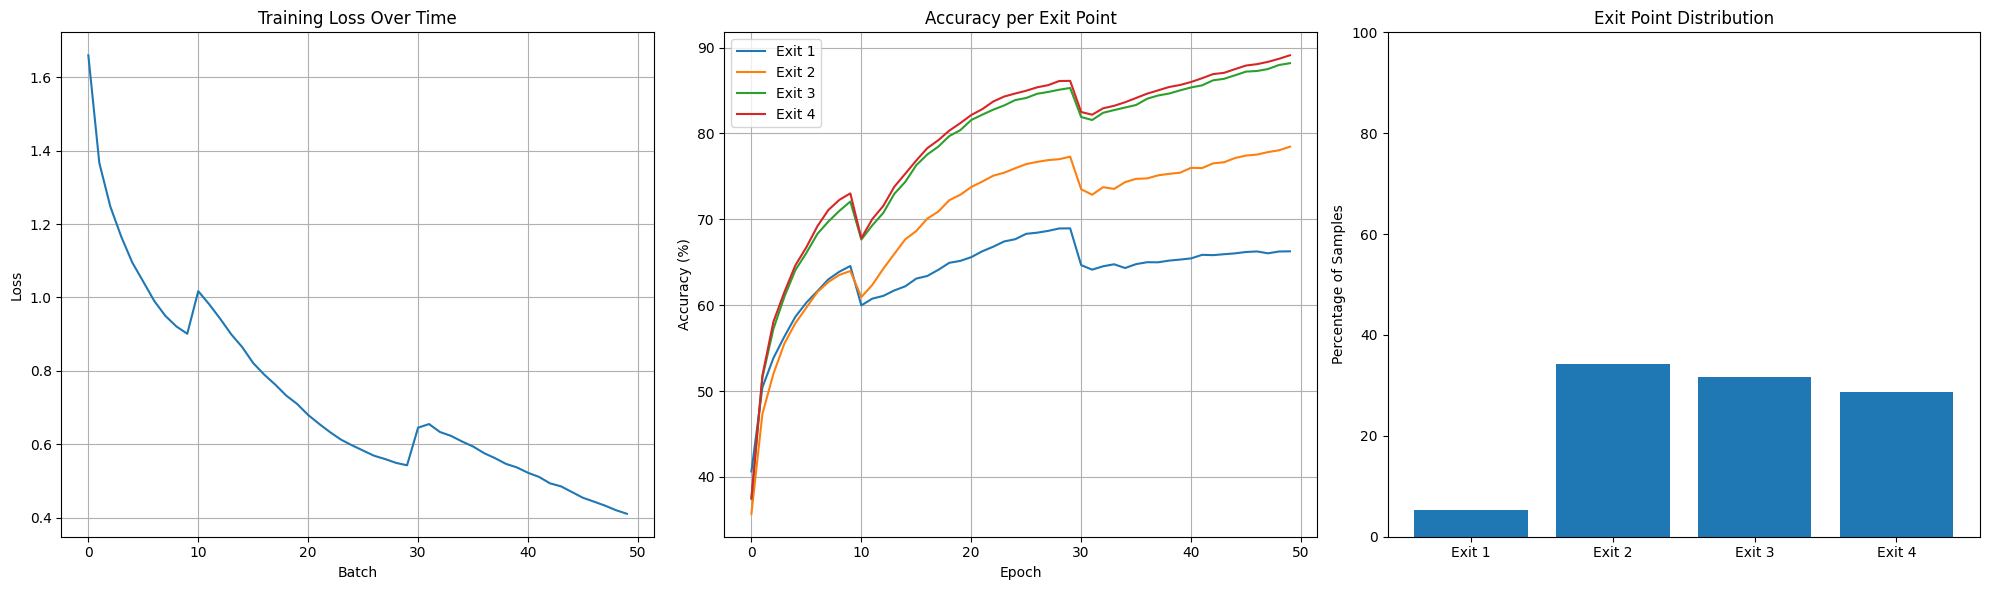

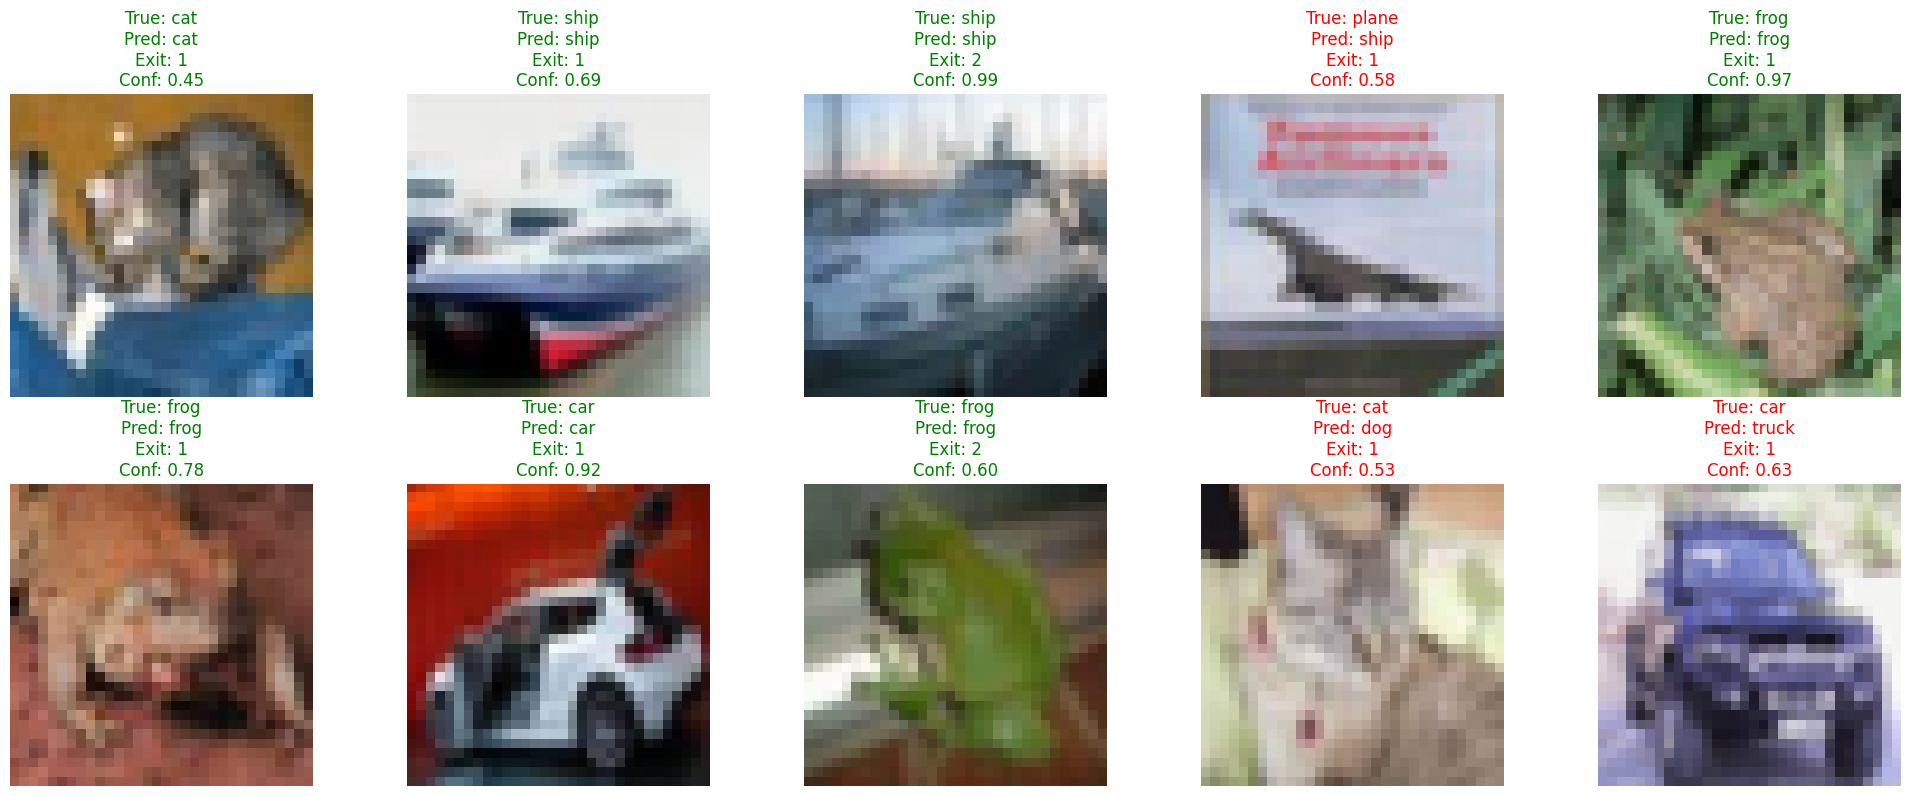

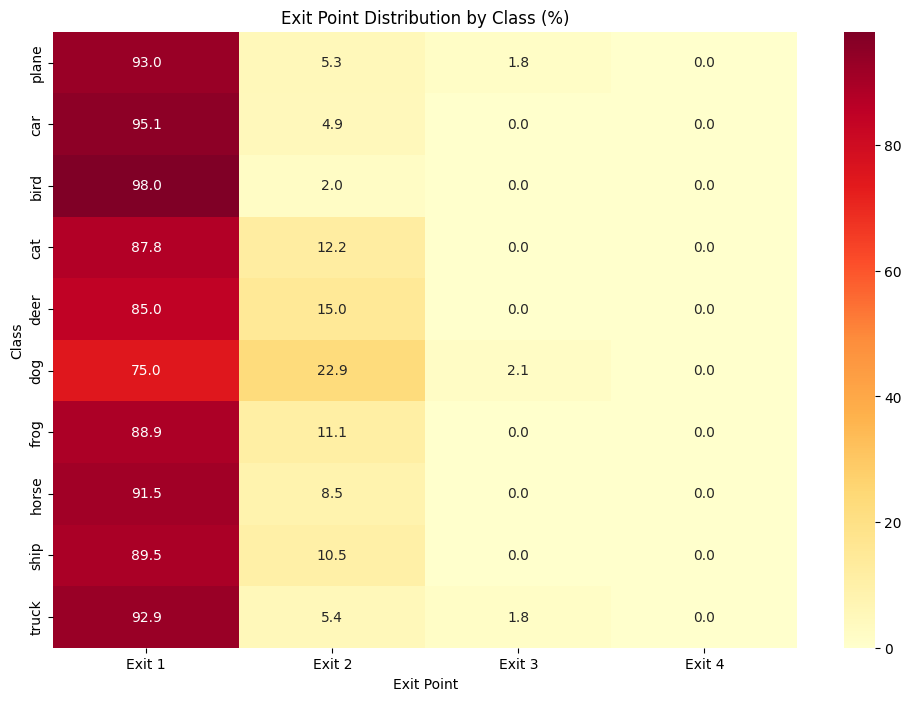

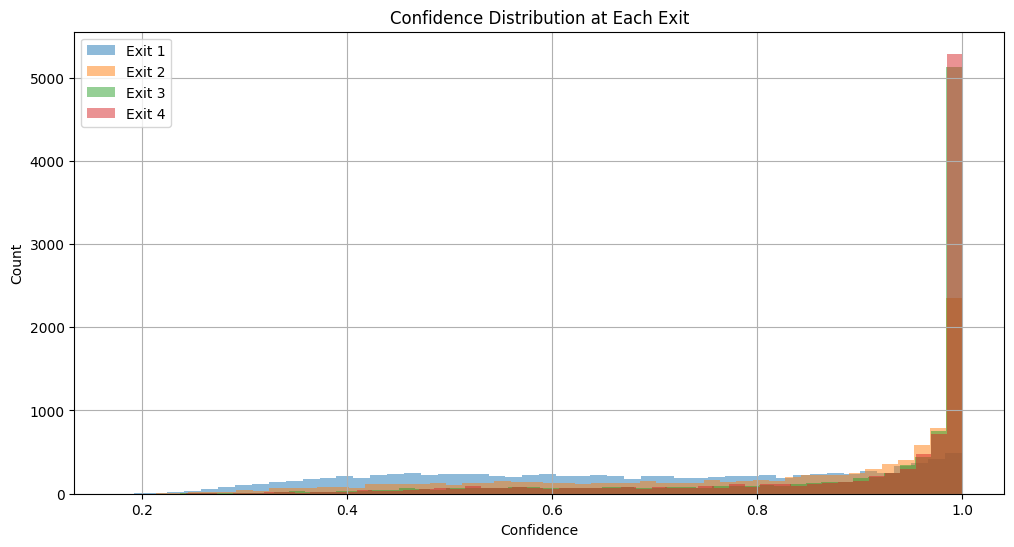

In [22]:
# Execute training pipeline
trained_cnn, trained_agent, evaluation_metrics, exit_metrics = run_training_pipeline()